# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


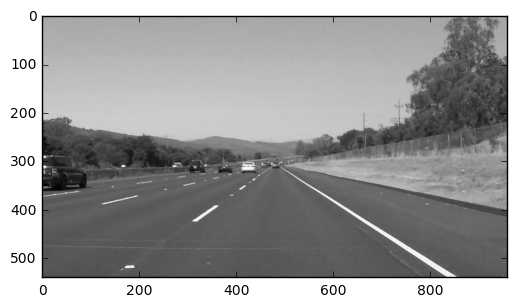

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
#plt.imshow(image) 

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
from statistics import mean

def best_fit_slop_and_intercept(xs,ys):
    m = ( ((mean(xs) * mean(ys)) - mean(xs*ys)) / ((mean(xs) * mean(xs)) - mean(xs*xs)) )
    b = mean(ys) - m * mean(xs)
    return m, b

    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    
    Calculate the slope of each line, remove horizontal lines 
    then divide lines into left and right sides ready for linear regresion"""
    global p_right
    global p_left
    
    x_right = np.array([])
    y_right = np.array([])
    x_left = np.array([])
    y_left = np.array([])
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x2-x1) != 0:
                slope = ((y2-y1)/(x2-x1))
                if (slope > line_slope_threshold or slope < -line_slope_threshold):
                    if slope > 0:
                        x_right = np.append(x_right,[x1,x2],axis=0)
                        y_right = np.append(y_right,[y1,y2],axis=0)
                        
                    else:
                        x_left = np.append(x_left,[x1,x2],axis=0)
                        y_left = np.append(y_left,[y1,y2],axis=0)
                        
    #Perform linier regresion on left/right lists of lines
    if len(x_right) > 0 and len(y_right) > 0:
        m_right, c_right = best_fit_slop_and_intercept(x_right, y_right)
        y_max = img.shape[0]
        x1_right = 0 
        y1_right = int(c_right)
        x2_right = int((y_max-c_right)/m_right)
        y2_right = y_max
        
    if len(x_left) > 0 and len(y_left) > 0:
        m_left, c_left = best_fit_slop_and_intercept(x_left, y_left)
        x1_left = 0
        y1_left = int(c_left)
        x2_left = int(-c_left/m_left)
        y2_left = 0
    
    """Merge with line from previouse frame, if frame has no lines then use last frane lines
       unless this is the first frame."""
    if len(x_right) > 0 and len(y_right) > 0:  
        if len(p_right) > 0:
            p_right[0] = (x1_right+p_right[0])/2
            p_right[1] = (y1_right+p_right[1])/2
            p_right[2] = (x2_right+p_right[2])/2
            p_right[3] = (y2_right+p_right[3])/2
        else: 
            p_right.append(x1_right)
            p_right.append(y1_right)
            p_right.append(x2_right)
            p_right.append(y2_right)
    
    if len(x_left) > 0 and len(y_left) > 0: # if frame has no lines then use last frane lines
        if len(p_left) > 0:
            p_left[0] = (x1_left+p_left[0])/2
            p_left[1] = (y1_left+p_left[1])/2
            p_left[2] = (x2_left+p_left[2])/2
            p_left[3] = (y2_left+p_left[3])/2
        else:
            p_left.append(x1_left)
            p_left.append(y1_left)
            p_left.append(x2_left)
            p_left.append(y2_left)
    
    #print line to black background
    if len(p_right) > 0: # this avoids errors if first frame returns no lines
        cv2.line(img, (0, int(p_right[1])), (int(p_right[2]), int(p_right[3])), color, thickness)
    if len(p_left) > 0: # this avoids errors if first frame returns no lines
        cv2.line(img, (0, int(p_left[1])), (int(p_left[2]), 0), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def extract_color(img, lower_color=np.array([110,100,100]), upper_color=np.array([130,255,255])):
    """
    Function to extract a colored object from an image,
    converts BGR to HSV,
    extracts a mask of only the required color,
    returns bitewise-AND of the original image and the mask.
    NB: the default color here is blue.
    """

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Threshold the HSV image to get only required colors
    mask = cv2.inRange(hsv, lower_color, upper_color)
    
    # return Bitwise-AND of mask and original image
    col = cv2.bitwise_and(img,img, mask= mask)
    #col_or = cv2.cvtColor(col, cv2.COLOR_HSV2BGR)
    return col

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

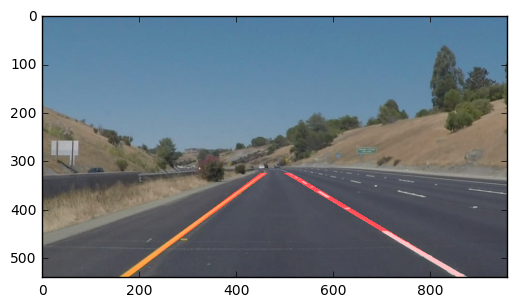

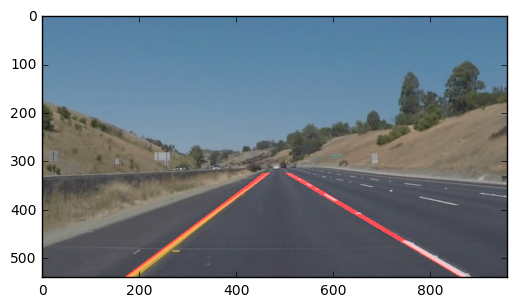

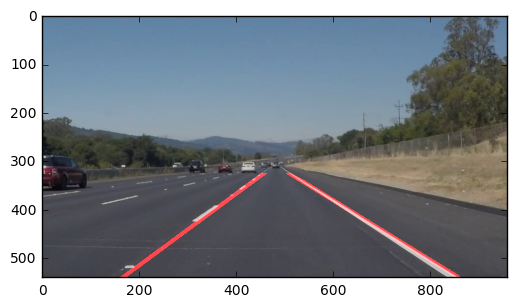

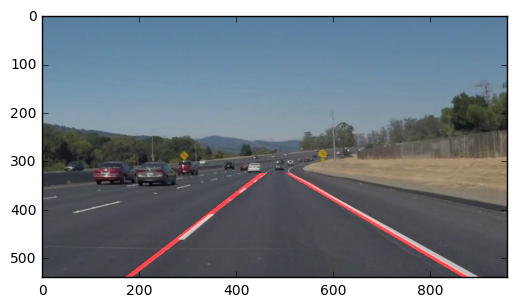

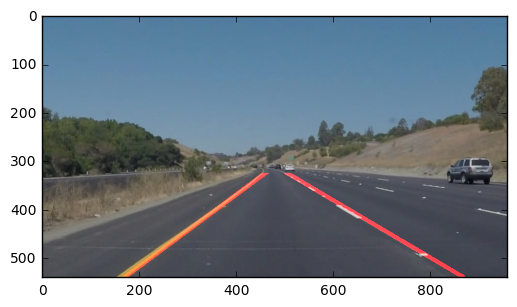

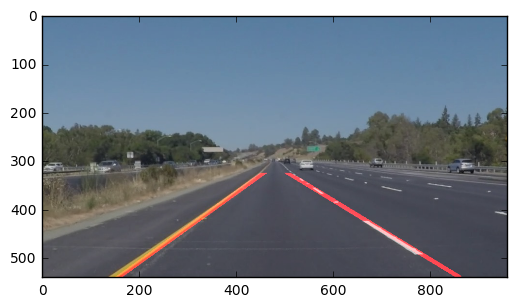

In [4]:
import os

#useful variables:
IMAGE_DIR = "test_images/"  #image directory
image_list = os.listdir(IMAGE_DIR) #list of image files
kernal_size = 5 #Gaussian blur kernal size
canny_low_threshold = 100 #low canny edge function threshold
canny_high_threshold = 150 #high canny edge function threshold
#these parameters help define the image mask shape:
top_horizontal = 30 #offset from center of image, applied (-/+) to both top corners of polygon
top_vertical= 55 #offset from center of image, applied (-) to both top corners of polygon
bottom_horizontal = 20 #offset from side of image, applied (+/-) to both bottom corners of polygon
bottom_vertical = 0 #offset from base of image, applied (+) to both bottom corners of polygon
#Hough transform parameters:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/90 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 10 #minimum number of pixels making up a line
max_line_gap = 200   # maximum gap in pixels between connectable line segments
#line parameters, these help sort the lines into relevant groupes and also eliminate noise:
line_slope_threshold = 0.5  #This helps remove lines that tend towards the horizontal thus cannot be lane line
#colour thresholds:
low_yellow = np.array([20,100,100])
high_yellow = np.array([255,255,255])

#global variables
last_masked_line_img = np.array([]) # not in use
p_right = []
p_left = []

#image processing pipeline function
def pipeline(image):
    #Global previouse fram lane lines
    global last_masked_line_img
    
    #highlight yellow lanes by extracting yellow color
    yellow = extract_color(image,low_yellow,high_yellow)
    y_gray = grayscale(yellow)

    #fade to gray
    gray = grayscale(image)
    new_gray = weighted_img(y_gray, gray, 0.8, 1.5)
    #plt.imshow(_new_gray,cmap='gray')
    #smooth it out
    blur_gray = gaussian_blur(new_gray, kernal_size)
    
    #get canny edges
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
    
    #define mask shape
    imshape = image.shape
    vertices = np.array([[(0+bottom_horizontal,imshape[0]-bottom_vertical),((imshape[1]/2)-top_horizontal, (imshape[0]/2)+top_vertical), ((imshape[1]/2)+top_horizontal, (imshape[0]/2)+top_vertical), (imshape[1]-bottom_horizontal,imshape[0]+bottom_vertical)]], dtype=np.int32)
    
    #apply mask to canny edges
    masked_edges = region_of_interest(edges, vertices)
    
    #run Hough transform to extract lines from masked region and draw on a blank image
    lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    #apply mask to line image from hough transform
    masked_lines_image = region_of_interest(lines_image, vertices)
    
    lane_line_img = weighted_img(masked_lines_image, image)
    
    return lane_line_img

#Process for each image in list
for image_name in image_list:
    #load image
    image = mpimg.imread(IMAGE_DIR+image_name)
    
    #call pipeline
    lane_line_image = pipeline(image)

    #plot results
    plt.figure()
    plt.imshow(lane_line_image)
    
    #save results



run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    #highlight yellow lanes by extracting yellow color
    yellow = extract_color(image,low_yellow,high_yellow)
    y_gray = grayscale(yellow)

    #fade to gray
    gray = grayscale(image)
    new_gray = weighted_img(y_gray, gray,0.8,1.5)
    
    #smooth it out
    blur_gray = gaussian_blur(gray, kernal_size)
    
    #get canny edges
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
    
    #define mask shape
    imshape = image.shape
    vertices = np.array([[(0+bottom_horizontal,imshape[0]-bottom_vertical),((imshape[1]/2)-top_horizontal, (imshape[0]/2)+top_vertical), ((imshape[1]/2)+top_horizontal, (imshape[0]/2)+top_vertical), (imshape[1]-bottom_horizontal,imshape[0]+bottom_vertical)]], dtype=np.int32)
    
    #build mask
    masked_edges = region_of_interest(edges, vertices)
   
    #run Hough transform to extract lines from masked region and draw on a blank image
    lines_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    #apply mask to line image from hough transform
    masked_lines_image = region_of_interest(lines_image, vertices)
    
    #merge Hough masked lines with the original image
    lane_line_img = weighted_img(masked_lines_image, image)
    
    return lane_line_img
    

Let's try the one with the solid white lane on the right first ...

In [7]:

white_output = 'white2.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white2.mp4
[MoviePy] Writing video white2.mp4


100%|█████████▉| 221/222 [00:18<00:00, 11.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white2.mp4 

CPU times: user 45 s, sys: 1.98 s, total: 47 s
Wall time: 19.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow4.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow4.mp4
[MoviePy] Writing video yellow4.mp4


100%|█████████▉| 681/682 [01:05<00:00, 10.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow4.mp4 

CPU times: user 2min 38s, sys: 6.27 s, total: 2min 45s
Wall time: 1min 6s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

The pipeline I am using does the following:
Extracts the colour yellow into s separate image.
Converts the original and yellow image to gray.
Merges the two gray images.
Smooths the image with a Gaussian  blur.
Defines an area of interest on the image.
Runs canny edge to extract edges.
Runs Hough transform on masked image. to extract lines
Removes lines tending towards the horizontal.
Separates the lines into left and right buckets and defines best fit line coordinates for each side.
Merges the lane lines with those from the previous frame if they exist, to reduce jitter.
Merges the resulting lane lines with the original and returns the result.

I have used the same pipeline for the images as well as the videos, including the optional challenge.  This gives sub-optimal performance on the images due to the inclusion of the line from the previous frame in the algorithm (easy to rectify).
The main downside to this pipeline is its inability to deal with curves in the road.  To this end the best fit algorithm that defines a unique line for each side of the lane could be modified to deal with curbs (specifically in the distance).  This would allow the extension of the masked area into the distance.  Also the ability to reduce the masked area as the curve in the road becomes acute, would stop the lines extending beyond the road.
If this happens then it would be a good idea to introduce and algorithm to recognise vehicles which would eliminate false positives from cars in front and in the adjacent lanes.
Working with an image in HSV instead of BGR may also improve performance in difficult light conditions.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
i_max=0
j_max=0
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:41<00:00,  6.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 33s, sys: 3.68 s, total: 1min 37s
Wall time: 43.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))